<a href="https://colab.research.google.com/github/aureliosaraiva/UniversidadEuropeaTFM/blob/main/tfm_etl_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets sentence-transformers faiss-cpu -q



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import json
import torch
import faiss
from google.colab import files
from datasets import load_dataset
from transformers import BloomTokenizerFast, BloomForCausalLM, Trainer, TrainingArguments
from datasets import Dataset
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

os.environ["WANDB_DISABLED"] = "true"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
from google.colab import files
import os

uploaded = files.upload()

for nome_original in uploaded.keys():
    novo_nome = 'dataset_raw.ndjson'
    os.rename(nome_original, novo_nome)

Saving dataset.ndjson to dataset.ndjson


In [ ]:
from google.colab import files
import json
import os

# Função para extrair os campos importantes de cada objeto JSON
def extract_fields(service_obj):
    """
    Extrai os campos:
      - name: metadata.name
      - description: metadata.description
      - dependsOn: se existir o campo 'dependsOn'; caso contrário, utiliza spec.consumesApis
      - labels: metadata.labels
    """
    metadata = service_obj.get("metadata", {})
    name = metadata.get("name", "")
    description = metadata.get("description", "")
    labels = metadata.get("labels", {})

    # Se não houver 'dependsOn', tenta usar spec.consumesApis
    spec = service_obj.get("spec", {})
    dependsOn = service_obj.get("dependsOn", spec.get("consumesApis", []))
    # Garante que dependsOn seja uma lista
    if not isinstance(dependsOn, list):
        dependsOn = [dependsOn]

    return {
        "name": name,
        "description": description,
        "dependsOn": dependsOn,
        "labels": labels
    }


def extract_fields_to_text(service_obj):
    """
    Extrai os campos:
      - name: metadata.name
      - description: metadata.description
      - dependsOn: se existir o campo 'dependsOn'; caso contrário, utiliza spec.consumesApis
      - labels: metadata.labels
    """
    metadata = service_obj.get("metadata", {})
    name = metadata.get("name", "")
    description = metadata.get("description", "")
    labels = metadata.get("labels", {})

    # Se não houver 'dependsOn', tenta usar spec.consumesApis
    spec = service_obj.get("spec", {})
    dependsOn = service_obj.get("dependsOn", spec.get("consumesApis", []))
    # Garante que dependsOn seja uma lista
    if not isinstance(dependsOn, list):
        dependsOn = [dependsOn]
    return f"""
Microservice Info:
Name: {name}
Description: {description}
Dependencies: {", ".join(dependsOn)}
Labels: {", ".join(labels)}
    """

# Lê o arquivo NDJSON linha a linha e converte cada linha para um objeto JSON
data = []
with open("dataset_raw.ndjson", "r") as f:
    for line in f:
        line = line.strip()
        if line:  # ignora linhas vazias
            data.append(json.loads(line))

def save_to_json():
    dataset = [extract_fields(service) for service in data]
    output_filename = "dataset_output.ndjson"
    if os.path.exists(output_filename):
        os.remove(output_filename)
    with open(output_filename, "w") as f:
        for record in dataset:
            f.write(json.dumps(record) + "\n")

    print(f"Arquivo JSON '{output_filename}' criado com sucesso!")

def save_to_text():
    dataset = [extract_fields_to_text(service) for service in data]
    output_filename = "dataset_output.text"
    if os.path.exists(output_filename):
        os.remove(output_filename)
    with open(output_filename, "w") as f:
        for record in dataset:
            f.write(json.dumps(record) + "\n")

    print(f"Arquivo TEXT '{output_filename}' criado com sucesso!")

save_to_json()
save_to_text()

Arquivo JSON 'dataset_output.ndjson' criado com sucesso!
Arquivo TEXT 'dataset_output.text' criado com sucesso!


In [ ]:
def extract_info(entry):
    return {
        'name': entry['metadata']['name'],
        'description': entry['metadata'].get('description', ''),
        'owner': entry['spec']['owner'],
        'tribe': entry['metadata']['annotations'].get('creditas.io/tribe', ''),
        'language': entry['metadata']['annotations'].get('creditas.io/language', ''),
        'dependencies': entry['spec'].get('dependsOn', []),
        'tags': entry['metadata'].get('tags', []),
        'full_context': str(entry)  # Contexto completo para o QA
    }

df = pd.DataFrame([extract_info(c) for c in data])

# Salvar contexto completo para retrieval
df['full_context'].to_csv('contextos_microservices.csv', index=False)


In [ ]:
qa_pairs = []
df_sample = df.sample(frac=0.2, random_state=42)
for _, row in df_sample.iterrows():
    context = str(row['full_context'])

    # Gerar perguntas automáticas baseadas na estrutura
    qa_pairs.append({
        'question': f"Qual é o dono do serviço {row['name']}?",
        'answer': row['owner'],
        'context': context
    })

    qa_pairs.append({
        'question': f"Que linguagem é usada no {row['name']}?",
        'answer': row['language'],
        'context': context
    })

    qa_pairs.append({
        'question': f"Lista as dependências do serviço {row['name']}",
        'answer': ', '.join(row['dependencies']),
        'context': context
    })

    qa_pairs.append({
        'question': f"Quais tags estão associadas ao {row['name']}?",
        'answer': ', '.join(row['tags']),
        'context': context
    })

# Converter para DataFrame
qa_examples = pd.DataFrame(qa_pairs)

In [ ]:
with open("dataset_raw.ndjson", "r") as file:
    dados = [json.loads(line) for line in file]

dataset_raw = Dataset.from_dict({"text": dados})

In [ ]:
dataset_raw

Dataset({
    features: ['text'],
    num_rows: 750
})

In [ ]:
# =============================================================================
# 3. Formatação dos Exemplos para Treinamento
# =============================================================================
# Para cada registro, criamos um prompt que reúne os campos extraídos.
def format_prompt(example):
    component = example['text']['metadata']

    name = component.get("name", "N/A")
    description = component.get("description", "N/A")
    dependsOn = component.get("dependsOn", [])
    if isinstance(dependsOn, list):
        dependsOn = ", ".join(dependsOn)
    labels = component.get("labels", {})
    # Utiliza json.dumps com default=str para converter objetos não serializáveis (por exemplo, datetime)
    prompt = (
        f"Microservice Info:\n"
        f"Name: {name}\n"
        f"Description: {description}\n"
        f"Dependencies: {dependsOn}\n"
        f"Labels: {json.dumps(labels, default=str)}\n\n"
        f"Treinamento:"
    )
    return {"text": prompt}

# Aplica a função de formatação ao dataset.
dataset = dataset_raw.map(format_prompt)

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

In [ ]:

# ------------------------------------------------------------------------------
# 2. Preparar o corpus de microserviços e criar o índice de recuperação
# ------------------------------------------------------------------------------
# Suponha que o campo "info" dos microserviços contenha as informações relevantes.
microservices_texts = [ms.get("text", "") for ms in dataset]

# Usamos um modelo de embeddings para gerar representações dos textos.
embedder = SentenceTransformer("paraphrase-MiniLM-L6-v2")
print("Gerando embeddings dos microserviços...")
embeddings = embedder.encode(microservices_texts, show_progress_bar=True)
embeddings = np.array(embeddings).astype("float32")

# Cria um índice FAISS para busca por similaridade.
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)
print(f"Índice FAISS criado com {index.ntotal} vetores.")

def get_context(question, top_k=3):
    """
    Dado uma pergunta, gera o embedding dela e recupera os top_k microserviços
    mais relevantes. O contexto é a concatenação das informações dos microserviços.
    """
    question_embedding = embedder.encode([question])
    question_embedding = np.array(question_embedding).astype("float32")
    distances, indices = index.search(question_embedding, top_k)
    context_list = [microservices_texts[i] for i in indices[0]]
    return "\n".join(context_list)

Gerando embeddings dos microserviços...


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Índice FAISS criado com 750 vetores.


In [ ]:
# ------------------------------------------------------------------------------
# 3. Preparar os exemplos de QA para treinamento
# ------------------------------------------------------------------------------
# Carregue o tokenizer e o modelo (neste exemplo usamos uma variante menor para economizar espaço)
tokenizer = BloomTokenizerFast.from_pretrained("bigscience/bloom-560m")
model = BloomForCausalLM.from_pretrained("bigscience/bloom-560m")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def preprocess_function(example):
    # Recupera o contexto com base na pergunta do exemplo
    context = get_context(example["question"], top_k=3)
    # Cria o prompt combinando o contexto com a pergunta e indica o início da resposta.
    prompt = f"Contexto:\n{context}\n\nPergunta: {example['question']}\nResposta:"
    # Concatena a resposta real para formar o texto completo de treinamento.
    full_text = prompt + " " + example["answer"]
    # Tokeniza o texto completo.
    tokenized = tokenizer(full_text, truncation=True, max_length=512, padding="max_length")
    # Define os labels como cópia dos input_ids para treinamento de language modeling.
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

# Converter os exemplos de QA para um Dataset do Hugging Face
qa_dataset = Dataset.from_dict(qa_examples)
# Aplica a função de pré-processamento a cada exemplo.
tokenized_dataset = qa_dataset.map(preprocess_function, batched=False)

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:
# ------------------------------------------------------------------------------
# 4. Configurar o Fine-Tuning com o Trainer
# ------------------------------------------------------------------------------
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",  # ou "epoch", se tiver um eval_dataset
    learning_rate=2e-5,
    # learning_rate=1e-5,  # taxa menor
    per_device_train_batch_size=2,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=2,
    fp16=True if device=="cuda" else False,
    report_to=[],  # desativa relatórios para wandb
    # max_grad_norm=1.0  # gradient clipping
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# ------------------------------------------------------------------------------
# 5. Iniciar o Treinamento
# ------------------------------------------------------------------------------
trainer.train()

Step,Training Loss
10,11.595000
20,15.938600
30,3.901100
40,2.844300
50,1.729900
60,0.857800
70,0.395300
80,0.511800
90,0.498800
100,0.343200


TrainOutput(global_step=300, training_loss=1.9003813211123148, metrics={'train_runtime': 185.7177, 'train_samples_per_second': 3.231, 'train_steps_per_second': 1.615, 'total_flos': 557224191590400.0, 'train_loss': 1.9003813211123148, 'epoch': 1.0})

[{'loss': 11.595, 'grad_norm': 39.14295959472656, 'learning_rate': 1.9733333333333336e-05, 'epoch': 0.03333333333333333, 'step': 10}, {'loss': 15.9386, 'grad_norm': 1519.2677001953125, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.06666666666666667, 'step': 20}, {'loss': 3.9011, 'grad_norm': 193.98858642578125, 'learning_rate': 1.8533333333333334e-05, 'epoch': 0.1, 'step': 30}, {'loss': 2.8443, 'grad_norm': inf, 'learning_rate': 1.7933333333333333e-05, 'epoch': 0.13333333333333333, 'step': 40}, {'loss': 1.7299, 'grad_norm': 234.1610870361328, 'learning_rate': 1.726666666666667e-05, 'epoch': 0.16666666666666666, 'step': 50}, {'loss': 0.8578, 'grad_norm': 292.8642272949219, 'learning_rate': 1.66e-05, 'epoch': 0.2, 'step': 60}, {'loss': 0.3953, 'grad_norm': 28.629484176635742, 'learning_rate': 1.5933333333333336e-05, 'epoch': 0.23333333333333334, 'step': 70}, {'loss': 0.5118, 'grad_norm': 19.326696395874023, 'learning_rate': 1.5266666666666667e-05, 'epoch': 0.26666666666666666, 'ste

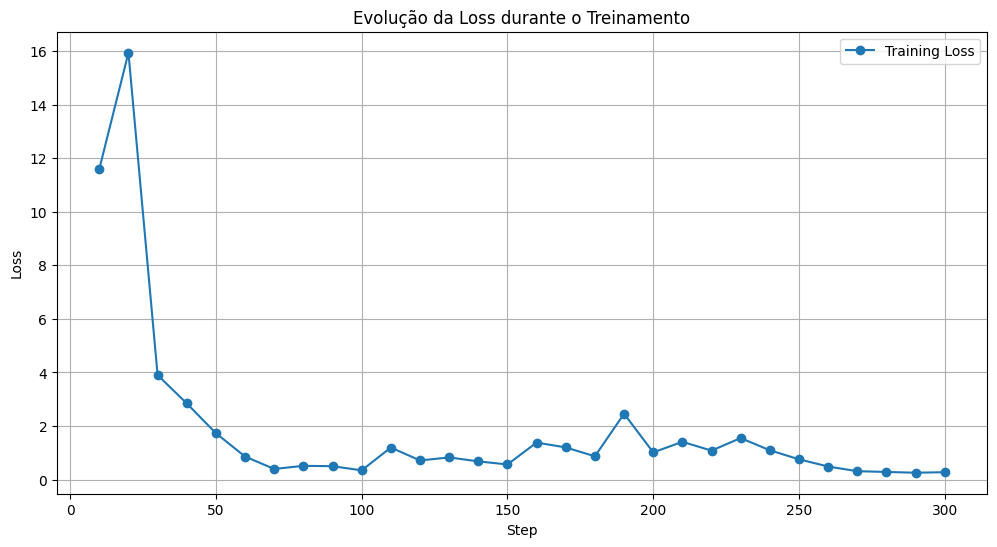

In [ ]:
# Extrai o histórico de logs
log_history = trainer.state.log_history

# Filtra apenas os logs que possuem a chave "loss"
loss_logs = [log for log in log_history if "loss" in log]

# Se desejar visualizar o histórico:
print(loss_logs)

# Converter para um DataFrame para facilitar a plotagem
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(loss_logs)
# Verifique se as colunas 'step' e 'loss' existem
print(df.columns)

# Caso os logs não contenham a coluna 'step', podemos tentar usar 'global_step'
if "step" not in df.columns and "global_step" in df.columns:
    df["step"] = df["global_step"]

plt.figure(figsize=(12, 6))
plt.plot(df["step"], df["loss"], marker='o', linestyle='-', label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Evolução da Loss durante o Treinamento")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ------------------------------------------------------------------------------
# 6. Etapa de Teste Manual: Fazer Perguntas ao Modelo
# ------------------------------------------------------------------------------
def answer_question(question, max_length=512, top_k=3, temperature=0.7):
    """
    Gera uma resposta para uma pergunta dada, utilizando o contexto recuperado
    dos microserviços e o modelo fine-tuned.
    """
    # Recupera o contexto relevante para a pergunta
    context = get_context(question, top_k=top_k)
    # Cria o prompt combinando o contexto e a pergunta
    prompt = f"Contexto:\n{context}\n\nPergunta: {question}\nResposta:"
    print("\nPrompt gerado para o modelo:")
    print(prompt)

    # Tokeniza o prompt
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    # Gera a resposta a partir do prompt
    output_ids = model.generate(
        input_ids,
        max_new_tokens=100,  # define quantos tokens serão gerados além do prompt
        do_sample=True,
        temperature=0.7,
        top_p=0.95,
        num_return_sequences=1
    )
    # Decodifica e retorna a resposta
    answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return answer

# Loop interativo para testar perguntas manualmente
print("\n=== Teste Interativo ===")
while True:
    user_question = input("\nDigite sua pergunta (ou 'sair' para encerrar): ")
    if user_question.strip().lower() == "sair":
        print("Encerrando o teste interativo.")
        break
    generated_answer = answer_question(user_question)
    print("\nResposta do modelo:")
    print(generated_answer)


=== Teste Interativo ===

Prompt gerado para o modelo:
Contexto:
Microservice Info:
Name: payroll-bff
Description: BFF de Benefícios, feito com Node e GraphQL, responsável por prover dados pro front-end e utilizado em várias aplicações, desde nosso MiniApp até no Edu por exemplo.
Dependencies: 
Labels: {"creditas.io/cliditas-api-version": "v2alpha1", "creditas.io/cliditas-version": "v0.9.35", "creditas.io/database-version": null, "creditas.io/disaster-recovery": null, "creditas.io/docker-image": "node-16.18.1-slim", "creditas.io/eventlib": null, "creditas.io/gradle-version": null, "creditas.io/impact": null, "creditas.io/java-version": null, "creditas.io/kotlin-jvm-version": null, "creditas.io/language": "TypeScript", "creditas.io/last-updated": "2025-01-09", "creditas.io/microservice-toolkit": null, "creditas.io/pcn": null, "creditas.io/sentry": null, "creditas.io/severity-critital": "6", "creditas.io/severity-high": "49", "creditas.io/severity-low": "13", "creditas.io/severity-moder